# UNKNOWN METRIC

In [101]:
import sys,os, math, glob, time
from builtins import zip
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, uniform
from sklearn.neighbors import KernelDensity
from sklearn.utils import shuffle
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
from opsimUtils import *
from astropy.io import fits
from astropy.stats import bayesian_blocks
%matplotlib inline

In [2]:
your_username = 'fragosta'

In [112]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.4/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_DD'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)

In [113]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [5]:
class TransienPM(BaseMetric):
#    Generate a population of transient objects and see what is its proper motion \n",
    def __init__(self, metricName='TransienPM', nexp=100, Mmin=10, Mmax=28, U=np.arange(-400,400,25), f='g', snr_lim=5,
             V=np.arange(-600,200,25),W=np.arange(-400,400,25),m5Col='fiveSigmaDepth', 
             mjdCol='observationStartMJD',filterCol='filter',seeingCol='seeingFwhmGeom', surveyduration=10, **kwargs):
        self.mjdCol = mjdCol
        self.seeingCol= seeingCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nexp = nexp
        self.snr_lim = snr_lim
        self.f = f
        self.U=U
        self.V=V
        self.W=W
        self.Mmin= Mmin
        self.Mmax= Mmax
        self.surveyduration = surveyduration 
        super(TransienPM, self).__init__(col=[self.mjdCol, self.m5Col,self.seeingCol, self.filterCol],
                                                  units='Fraction Detected',
                                                  metricName=metricName, **kwargs)

    # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
    def DF(self,V_matrix, mode):
        U,V,W=V_matrix[:][0],V_matrix[:][1],V_matrix[:][2]
        if mode== 'H':
            norm=0.02
            Va=200
            P=norm*np.exp(-((U/130)**2+((V-Va)/105)**2+(W/85)**2)/2)/np.sqrt(2*np.pi)/(130*105*85)
        elif mode=='B':
            norm=0.05
            Va=100
            P=norm*np.exp(-((U/120)**2+((V-Va)/95)**2+(W/75)**2)/2)/np.sqrt(2*np.pi)/(120*95*75)
        elif mode=='D':
            norm=0.98
            Va=10
            P=norm*np.exp(-((U/40)**2+((V-Va)/30)**2+(W/20)**2)/2)/np.sqrt(2*np.pi)/(40*30*20)
        return P

    def lightCurve(self, t, t0, peak, duration, slope):
#      A simple top-hat light curve.,
#        
#        Parameters\n",
#        ----------\n",
#        t : array\n",
#            Times to generate lightcurve points (mjd)\n",
#        t0 : float\n",
#            Initial time (mjd)\n",
#        m_r_0 : float\n",
#            initial r-band brightness (mags)\n",
        lightcurve = np.zeros(np.size(t), dtype=float) + 99.
# Select only times in the lightcurve duration window\n",
        good = np.where( (t >= t0) & (t <= t0+duration) )
        lightcurve[good] = peak + slope*(t[good]-t0)
        return lightcurve

    def run(self,  dataSlice, slicePoint=None):
        obs = np.where((dataSlice['filter']==self.f) & (dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration))
        names=['PM', 'PM_out','snr','timegap']
        variables = {k:[] for k in names}
        vel_out= uniform(-5000,5000)
        if len(dataSlice[self.m5Col][np.where(dataSlice['filter'][obs]==self.f)])>2: 
            for s in range(self.nexp):    
                tf = dataSlice[self.mjdCol][np.where(dataSlice['filter'][obs]==self.f)]
                dT = np.absolute(tf - shuffle(tf)) # dd                                                                          
                see=np.median(dataSlice[self.seeingCol]) # arcsec
                M = np.random.uniform(self.Mmax, self.Mmin)  # magAB                                                                        
                d = np.random.uniform(4, 1.2*10**5) # pc                                                                                 
                #### velocity distribution###                
                mode=''
                pos = np.random.rand()
                if pos <=1/3:
                    mode='B'
                elif pos>1/3 and pos<=2/3:
                    mode='D'
                elif pos>2/3 and pos<=1:
                    mode='H'
                V_matrix=np.vstack((self.U,self.V,self.W))
                velmat = np.zeros(len(V_matrix))
                veloutmat = np.zeros(len(V_matrix))
                Pv=self.DF(V_matrix, mode)
                Pord=np.sort(Pv)
                row=np.where(Pv==np.random.choice(Pord))

                for i in range(len(V_matrix)):
                    velmat[i]=V_matrix[i][row]
                    veloutmat[i]=vel_out.rvs()

                if mode=='B' or mode=='H':     
                    vT = np.sqrt(velmat[1]**2+velmat[2]**2)
                    vfT = np.sqrt(veloutmat[1]**2+veloutmat[2]**2)
                else:
                    vT = velmat[1]
                    vfT = veloutmat[1]

                mu= vT/4.75/d
                muf=vfT/4.75/d
                arc=muf*dT/365
                for i,a in enumerate(arc):
                    if a > 0.05*see and M<27:
                        variables['timegap'].append(dT[i])
                        variables['PM_out'].append(muf)
                        variables['PM'].append(mu)
                        variables['snr'].append(m52snr(M,np.median(dataSlice[self.m5Col][np.where(dataSlice['filter']==self.f)])))
                    else:
                        variables['timegap'].append(np.nan)
                        variables['PM_out'].append(np.nan)
                        variables['PM'].append(np.nan)
                        variables['snr'].append(np.nan)


        variables = {k:np.array([elem for elem in v if elem is not np.nan]) for k,v in variables.items()}                     
        objRate = 0.7 # how many go off per day\n",
        # decide how many objects we want to generate\n",
        nObj=len(variables['PM'])
        m0s = np.random.uniform(self.Mmax, self.Mmin, nObj)
        t = dataSlice[self.mjdCol][obs] - dataSlice[self.mjdCol].min()
        detected = np.zeros(variables['timegap'].size)
        # Loop though each generated transient and decide if it was detected\n",
        # This could be a more complicated piece of code, for example demanding \n",
        # A color measurement in a night.\n",
        
        for i,duration in enumerate(variables['timegap']):
            t0 = np.random.uniform(0,10)
            slope = np.random.uniform(-3,3)
            lc = self.lightCurve(t, t0, m0s[i],duration, slope)
            good = m52snr(lc,dataSlice[self.m5Col][obs])> self.snr_lim
            detectTest = dataSlice[self.m5Col][obs] - lc
            if detectTest.max() > 0 and len(good)>2:
                detected[i] += 1
        # Return the fraction of transients detected\n",
        if float(nObj) == 0:
            A = np.inf
        else:
            A=float(nObj)
        res = float(np.sum(detected))/A           
        #print('detected fraction:{}'.format(res))
        return res
    
    

In [6]:
class confusionmetric(BaseMetric):
    def __init__(self, filename = 'data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM', 'deltaX'], snr_lim=5,mode=None, MagIterLim=[0,1,1], surveyduration=10, metricName='confusionmetric',m5Col='fiveSigmaDepth', 
                 mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True,**kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.colsname = colsname
        self.snr_lim = snr_lim
        self.filename = filename 
        self.dataout = dataout
        self.mode = mode
        self.MagIterLim = MagIterLim
        self.surveyduration = surveyduration
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(confusionmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol,"night"],
                                                       units='', metricDtype='float',metricName=metricName,
                                                        **kwargs)
    def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data
    def run(self, dataSlice, slicePoint=None):
        
        colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
        data = readfile(self.filename, self.colsname)
        obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
        m5 = dataSlice[self.m5Col][obs]
        seeing= dataSlice[self.seeingCol][obs]
        filters = dataSlice['filter'][obs]
        g = np.array(data[self.colsname[2]])
        Hg = np.array(data[self.colsname[4]])
        gr = np.array(data[self.colsname[3]])
        #ID = np.isclose(np.radians(data[self.colsname[0]]),slicePoint['ra'],rtol=1e-5)& np.isclose(np.radians(data[self.colsname[1]]),slicePoint['dec'],rtol=1e-5)
        pm = np.array(data[self.colsname[5]])*1e-3
        #deltaX = np.array(data[self.colsname[6]])*1e-3
        #deltaT = deltaX/pm
        deltamag= np.arange(self.MagIterLim[0],self.MagIterLim[1],self.MagIterLim[2])
        #tf = see[np.where(filters==self.colsname[2])]
        #dT = np.absolute(tf - shuffle(tf))/365.
        #IDtime = np.isclose(dT,deltaT[ID], rtol=1e-3)
        #T = np.median(dT[IDtime]) 
        #sigmadT = deltaT[ID] - T
        out = {}
        fwhm = {}
        mag_lim = np.median(m5[np.where(filters==self.colsname[2])])
        for dm in deltamag:
            #mag= g[ID]+dm
            if self.mode == 'distance':
                pmnew= pm/(10**(dm/5))
            elif self.mode == 'density':
                pmnew= pm
            else:
                print('##### ERROR: the metric is not implemented for this mode.')
            s=np.median(seeing)
            sigmafw=0.67*s
            coeff= np.log(10)*5
            deltaX= pmnew*self.surveyduration
            good=np.empty(len(Hg))
            for i, (h, p) in enumerate(zip(Hg,pmnew)):
                mag= g[i]+dm
                snr = m52snr(mag,mag_lim)
                if snr>self.snr_lim and deltaX[i] > 0.05*s:
                    #sigmaHg=np.sqrt(snr**(-2)*(1+(sigmafw*coeff/pmnew[ID]/self.surveyduration)**2))#+(coeff*sigmadT)**2)
                    sigmaHg=np.sqrt(snr**(-2)*(1+(sigmafw*coeff/p/self.surveyduration)**2))#+(coeff*sigmadT)**2)
                    good_Hg = np.size(np.where((Hg>h-sigmaHg) &(Hg< h+sigmaHg)))/np.size(Hg)
                    good_gr = np.size(np.where((gr>gr[i]-snr**(-1)) &(gr<gr[i]+snr**(-1))))/np.size(Hg)
                    #good_Hg = np.size(np.where((Hg>Hg[ID]-sigmaHg) &(Hg< Hg[ID]+sigmaHg)))/np.size(Hg)
                    #good_gr = np.size(np.where((gr>gr[ID]-snr**(-1)) &(gr<gr[ID]+snr**(-1))))/np.size(Hg)
                    if good_Hg==good_gr:
                        good[i] = good_Hg
                    else:
                        good[i] = max([good_Hg,good_gr])
                else:
                    good[i] = 0
            out[dm] = {'num':good, 'Hg': Hg,'g-r': gr}
        #print(out)
        if self.dataout:
            return out 
        else:
            DM = np.array([out[dm]['num'] for dm in out.keys()])
            #weight = 1/np.array([fwhm[dm] for dm in fwhm.keys()])**2
            alpha = DM[np.where(DM !=0)].sum()#*weight[np.where(DM !=0)]/weight[np.where(DM !=0)].sum()
            res = (np.size(DM[np.where(DM !=0)])/np.size(DM))/alpha.sum()
            #print('Confusion Index={}'.format(res))
            return res
        
        

In [7]:
class LSPMmetric(BaseMetric):
    def __init__(self, metricName='LSPMmetric',U=np.arange(-400,400,25), f='g',surveyduration=10,snr_lim=5,
                 V=np.arange(-600,200,25),W=np.arange(-400,400,25),m5Col='fiveSigmaDepth', 
                 mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom', nexp= 1,dataout=False,
                 **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol= filterCol
        self.surveyduration =surveyduration
        self.snr_lim = snr_lim
        self.f = f
        self.nexp = nexp
        self.U=U
        self.V=V
        self.W=W
        self.dataout = dataout
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(LSPMmetric, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol,"night"],
                                                       units='Proper Motion relative error', metricName=metricName,
                                                        **kwargs)
    
    
    # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
    
    def histogram_intersection(self,h1, h2):
        v1,b1=np.histogram(h1,'auto')
        v2,b2=np.histogram(h2,'auto')
        if b1[0]< b2[0]:
            Bint= np.where((b2[:-1]>b1[0])&(b2[:-1]<b1[-1]))
        else:
            Bint= np.where((b1[:-1]>b2[0])&(b1[:-1]<b2[-1]))
        if np.size(Bint)==0:
            res = 0
        else:
            area= np.dot(v1,b1[:-1])
            if np.size(Bint)< np.size(b1):
                areaint = np.dot(v1[Bint], b1[Bint])
            else:
                areaint = np.dot(v2[Bint], b2[Bint])
            res= areaint/area
        return res
    def DF(self,V_matrix, mode):
        U,V,W=V_matrix[:][0],V_matrix[:][1],V_matrix[:][2]
        if mode== 'H':
            norm=0.02
            Va=200
            P=norm*np.exp(-((U/130)**2+((V-Va)/105)**2+(W/85)**2)/2)/np.sqrt(2*np.pi)/(130*105*85)
        elif mode=='B':
            norm=0.05
            Va=100
            P=norm*np.exp(-((U/120)**2+((V-Va)/95)**2+(W/75)**2)/2)/np.sqrt(2*np.pi)/(120*95*75)
        elif mode=='D':
            norm=0.98
            Va=10
            P=norm*np.exp(-((U/40)**2+((V-Va)/30)**2+(W/20)**2)/2)/np.sqrt(2*np.pi)/(40*30*20)
        return P
    
    def Likelihood(self, variables, ty= ''):
        if ty == 'usual':
            pmname = 'PM'
            velname = 'VEL'
        elif ty == 'unusual':
            pmname = 'PM_out'
            velname = 'VEL_out'
        else:
            print('you need to define the proper motion object type [usual or unusual]')
            
        a =np.exp(variables['position']**2*(np.cos(variables['DEC']**2))) 
        b = np.exp(variables['position']**2*(np.cos(variables['DEC'])**2+(variables['position']**2*(np.sin(variables['DEC']**2))))) 
        c =np.exp(variables['position']**2*(np.cos(variables['DEC'])**2+(variables['position']**2*(np.sin(variables['DEC']**2)))))
        Norm= np.array([(a[i]*self.DF(variables['VEL'][i],mode='D')+b[i]*self.DF(variables['VEL'][i],mode='H')+c*self.DF(variables['VEL'][i],mode='B')) for i, mode in enumerate(variables['MODE'])])
        Pmdt = np.exp(-(0.07-variables[pmname]*variables['timegap']/0.67/variables['FWHM'])**2*variables['snr']**2)
        Px = np.array([np.exp(-variables['position'][i]*(1+np.sin(variables['DEC'][i])))* self.DF(variables[velname][i],mode=variables['MODE'][i])/Norm[i] for i, mode in enumerate(variables['MODE'])])
        L= Px*Pmdt
        return L
    
    def LScore(self, like, variables):
        norm= np.sum(0.67*np.sqrt(np.pi)*variables['FWHM']*np.log(variables['timegap'])/2/variables['PM'])
        lam=-2*(np.log(like)-np.log(norm))
        mask= np.isfinite(lam)
        res = np.where(lam==np.inf, 0,lam)
        return res
                     
    def run(self, dataSlice, slicePoint=None):
        np.random.seed(np.random.randint(5000))
        names=['VEL','VEL_out', 'position','MODE','timegap','PM', 'PM_out','FWHM','DEC','snr']
        variables = {k:[] for k in names}#np.zeros(self.nexp, dtype=list(zip(names, [float]*len(names))))
        vel_out= uniform(-1000,1000)
        obs = np.where((dataSlice['filter']==self.f) & (dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration))
        if len(dataSlice[self.m5Col][obs])>2:
            tf = dataSlice[self.mjdCol][obs]
            see=np.median(dataSlice[self.seeingCol][obs]) # arcsec
            for s in range(self.nexp):    
                dT = np.absolute(tf - shuffle(tf)) # dd            
                M = np.random.uniform(15,28)  # magAB  
                snr = m52snr(M, np.median(dataSlice[self.m5Col][obs])) # arcsec)
                d = np.random.uniform(4, 1.2*10**5) # pc                                                                                 
                #### velocity distribution###                
                mode=''
                pos = np.random.rand()
                if pos <=1/3:
                    mode='B'
                elif pos>1/3 and pos<=2/3:
                    mode='D'
                elif pos>2/3 and pos<=1:
                    mode='H'
                V_matrix=np.vstack((self.U,self.V,self.W))
                velmat = np.zeros(len(V_matrix))
                veloutmat = np.zeros(len(V_matrix))
                Pv=self.DF(V_matrix, mode)
                Pord=np.sort(Pv)
                row=np.where(Pv==np.random.choice(Pord))

                for i in range(len(V_matrix)):
                    velmat[i]=V_matrix[i][row]
                    veloutmat[i]=vel_out.rvs()

                if mode=='B' or mode=='H':     
                    vT = np.sqrt(velmat[1]**2+velmat[2]**2)
                    vfT = np.sqrt(veloutmat[1]**2+veloutmat[2]**2)
                else:
                    vT = velmat[1]
                    vfT = veloutmat[1]

                mu= vT/4.75/d
                muf=vfT/4.75/d
                arc=muf*dT/365
                for i,a in enumerate(arc):
                    if a > 0.05*see:# and snr>self.snr_lim:
                        variables['position'].append(np.random.uniform(0,1))                                                                              
                        variables['MODE'].append(mode)
                        variables['timegap'].append(dT[i])
                        variables['PM_out'].append(muf)
                        variables['PM'].append(mu)
                        variables['DEC'].append(np.median(dataSlice['fieldDec']))
                        variables['FWHM'].append(see)
                        variables['VEL'].append(velmat)
                        variables['VEL_out'].append(veloutmat)
                        variables['snr'].append(snr)
                    else:
                        variables['timegap'].append(np.nan)
                        variables['position'].append(np.nan)
                        variables['PM_out'].append(np.nan)
                        variables['PM'].append(np.nan)
                        variables['VEL'].append(np.nan)
                        variables['VEL_out'].append(np.nan)
                        variables['DEC'].append(np.nan)
                        variables['FWHM'].append(np.nan)
                        variables['snr'].append(np.nan)
                        variables['MODE'].append(np.nan)
                
            
            variables = {k:np.array([elem for elem in v if elem is not np.nan]) for k,v in variables.items()}
            like_PM = self.Likelihood(variables, ty='usual')
            like_PMout = self.Likelihood(variables, ty='unusual')
            lam = {'LS_PM':self.LScore(like_PM, variables), 'LS_PMout': self.LScore(like_PMout, variables)}
            if self.dataout:
                PM = {'PM': variables['PM'], 'PM_OUT':variables['PM_out']}
                return{'LS':lam}
            else:
                if len(lam['LS_PMout'])!=0 :
                    alpha = self.histogram_intersection(lam['LS_PM'],lam['LS_PMout'])
                    res = alpha
                    #print('intersection:{}'.format(alpha))
                else:
                    res = np.nan
                return res
            
        

In [8]:
U=np.arange(-400,400,5)
W=np.arange(-400,400,5)
V=np.arange(-600,200,5)
def readfile( filename='', colsname=['']):
        if 'csv' in filename:
            #print('reading {}'.format(filename))
            data = pd.read_csv(filename, header=0, names = colsname )
        elif 'fits' in filename:
            #print('reading {}'.format(filename))
            hdul = fits.open(filename)
            data = hdul[1].data
        elif ['txt', 'dat'] in filename:
            #print('reading {}'.format(filename))
            data = {k:[] for k in colsname}
            f = open(filename)
            righe = f.readlines()
            for line in righe:
                line.split()
                for i, k in enumerate(colsname):
                    data[k].append(float(line[i]))                
        elif 'json'in filename:
            print('not implemented to read .json extention')
        return data

### WFD or DDF

In [103]:
filename = 'data.csv'
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX']
data = readfile(filename, colsname)
transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']})
metric1 = LSPMmetric(f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom', nexp= 50,surveyduration = 2,dataout=False)
metric2 = TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',surveyduration=2, nexp= 50)
metric3 = confusionmetric(filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 2, MagIterLim=[2,3,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=False)
slicer3 = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec'])
sqlconstraint = 'proposalID>1'#' note not like "DD%"'
slicer = slicers.HealpixSlicer(nside=16)
metricSky1 = metricBundles.MetricBundle(metric1,slicer,sqlconstraint)
metricSky2 = metricBundles.MetricBundle(metric2,slicer,sqlconstraint)
metricSky3 = metricBundles.MetricBundle(metric3,slicer,sqlconstraint)
bundleDict={'like':metricSky1,'transient':metricSky2, 'confusion': metricSky3}


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [10]:
dbRuns[75]

'weather_1.2_ndt_v1.4_10yrs'

In [114]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/PM'.format(your_username)

# below I am only going to run metrics on the first five opsims
#for run in dbRuns:
for i, run in enumerate(dbRuns):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSky1.setRunName(run)
    metricSky2.setRunName(run)
    metricSky3.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

##############

N_1, wfd_depth_scale0.85_noddf_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
--- 0.08 minutes ---

####################

##############

N_2, twilight_neo_mod2_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
Found 237899 visits
Running:  ['like', 'transient', 'confusion']


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 2.46 minutes ---

####################

##############

N_3, weather_0.3_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
Found 204378 visits
Running:  ['like', 'transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.59 minutes ---

####################

##############

N_4, pair_strategy_4_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
Found 205985 visits
Running:  ['like', 'transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.92 minutes ---

####################

##############

N_8, roll_mod2_dust_sdf_0.20_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
Found 204620 visits
Running:  ['like', 'transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.72 minutes ---

####################

##############

N_9, pair_strategy_1_v1.4_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID>1 for columns ['filter', 'fiveSigmaDepth', 'night', 'seeingFwhmGeom', 'observationStartMJD', 'fieldRA', 'fieldDec']
Found 205319 visits
Running:  ['like', 'transient', 'confusion']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

In [118]:
#resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData'.format(your_username)
# get a dictionary of resultDb from given directory
resultDbs2 = getResultsDbs(outDir)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs2.keys())
bundleDicts = {}
for runName in runNames:
    bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

In [145]:
bundleDicts[runNames[0]].keys()

dict_keys([(1, 'LSPMmetric'), (2, 'TransienPM'), (3, 'confusionmetric')])

In [119]:
data, lam={},{}
for key in bundleDicts.keys():
    data[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0]
    lam[key]= []
    for i in range(len(data[key])):        
        if data[key][i]:
            lam[key].append(data[key][i])
    if len(np.array(lam[key])[np.isfinite(np.array(lam[key]))])!=0:
        lam[key]=np.hstack(np.array(lam[key])[np.isfinite(np.array(lam[key]))])
    else:
        lam[key]=np.array([])
data2, frac={},{}
for key in bundleDicts.keys():
    data2[key]=pd.DataFrame(bundleDicts[key][(2,'TransienPM')].metricValues[np.where(bundleDicts[key][(2,'TransienPM')].metricValues.mask == False)])[0]
    frac[key]= []
    for i in range(len(data2[key])):        
        if data2[key][i]:
            frac[key].append(data2[key][i])
    if len(np.array(frac[key])[np.isfinite(np.array(frac[key]))])!=0:
        frac[key]=np.hstack(np.array(frac[key])[np.isfinite(np.array(frac[key]))])
    else:
        frac[key]=np.array([])
data3, conf={},{}
for key in bundleDicts.keys():
    data3[key]=pd.DataFrame(bundleDicts[key][(3,'confusionmetric')].metricValues[np.where(bundleDicts[key][(3,'confusionmetric')].metricValues.mask == False)])[0]
    conf[key]= []
    for i in range(len(data3[key])):        
        if data3[key][i]:
            conf[key].append(data3[key][i])
    if len(np.array(conf[key])[np.isfinite(np.array(conf[key]))])!=0:
        conf[key]=np.hstack(np.array(conf[key])[np.isfinite(np.array(conf[key]))])
    else:
        conf[key]=np.array([])

In [122]:
output= pd.concat([pd.DataFrame(lam[key]) for key in bundleDicts.keys()],axis=1)
output.columns=bundleDicts.keys()
output.to_csv('likelihood_score_DD.csv', index=False)

In [182]:
c = pd.read_csv('confusion_index.csv')
f = pd.read_csv('fraction_transient.csv')
l = pd.read_csv('likelihood_score.csv')
conf, frac, lam = {},{},{}
for key in bundleDicts.keys():
    if len(np.array(c[key])[np.isfinite(np.array(c[key]))])!=0:
        conf[key]=np.hstack(np.array(c[key])[np.isfinite(np.array(c[key]))])
    else:
        conf[key]=np.array([])
    if len(np.array(f[key])[np.isfinite(np.array(f[key]))])!=0:
        frac[key]=np.hstack(np.array(f[key])[np.isfinite(np.array(f[key]))])
    else:
        frac[key]=np.array([])
    if len(np.array(l[key])[np.isfinite(np.array(l[key]))])!=0:
        lam[key]=np.hstack(np.array(l[key])[np.isfinite(np.array(l[key]))])
    else:
        lam[key]=np.array([])

In [69]:
coeff=open('norm_coeff_NEW.txt')
righe= coeff.readlines()
norm_coeff=[]
norm_keys=[]
for line in righe:
    loc=line.split()
    if '#' in loc:
        continue
    else:
        norm_keys.append(loc[0])
        norm_coeff.append(float(loc[1]))
norm_coeff=np.array(norm_coeff)  
norm_keys=np.array(norm_keys)  

In [159]:
name_tick=[]
for key in dbRuns:#bundleDicts.keys():
    #if 'noddf' in key:
    #    continue
    #else:
        n= key.split('_')
        if 'v1.4' in n:
            n.remove('v1.4')
        else:
            word=[]
            for s in n[-2]:
                word.append(s)
            word.remove('v')
            word.remove('1')
            word.remove('.')
            word.remove('4')
            sub =''
            n[-2]= sub.join(word)
        n.remove('10yrs')
        s=' '
        name_tick.append(s.join(n))

In [26]:
dbRuns[0]

'wfd_depth_scale0.85_noddf_v1.4_10yrs'

In [158]:
FomLS=np.empty(len(runNames))
FomPMT=np.empty(len(runNames))
FomC =np.empty(len(runNames))
#for i, key in enumerate(bundleDicts.keys()):
for i, key in enumerate(runNames):
    if 'noddf' in key:
        continue
    else:
        if len(lam[key])>0:
            ID_lam=np.where((lam[key]<1)& (np.isnan(lam[key])==False))
            #lv,lb =np.histogram(np.array(lam[key])[ID_lam],'auto')
            #l_fom = (lb[1:len(lb)]+lb[0:len(lb)-1])/2*lv
            #FomLS.append(l_fom.sum()/lv.sum()/(3*np.std(np.array(lam[key])[ID_lam]))*np.mean(np.array(lam[key])[ID_lam]))
            FomLS[i] = np.absolute(np.median(np.array(lam[key])[ID_lam])/(3*np.std(np.array(lam[key])[ID_lam]))*(len(ID_lam)))
        else:
            FomLS[i] = np.nan
            #FomLS.append(0)
        if len(conf[key])>0 and key in norm_keys:    
            ID_conf=np.where((conf[key]!=0)& (np.isnan(conf[key])==False))
            #cv,cb =np.histogram(np.array(conf[key])[ID_conf],'auto')
            #c_fom = (cb[1:len(cb)]+cb[0:len(cb)-1])/2*cv
            #FomC.append(c_fom.sum()/cv.sum()/(np.std(np.array(conf[key])[ID_conf]))*norm_coeff[i])
            FomC[i]=np.absolute(1- np.median(np.array(conf[key])[ID_conf])/(3*np.std(np.array(conf[key])[ID_conf])))*(len(ID_conf))#/norm_coeff[i]*(len(ID_conf))
        else:
            FomC[i] = np.nan
            #FomC.append(0)
        if len(frac[key])>0:
            ID_frac=np.where((np.isnan(frac[key])==False))
            #fv,fb=np.histogram(np.array(frac[key])[ID_frac],'auto') 
            #f_fom = (fb[1:len(fb)]+fb[0:len(fb)-1])/2*fv   
            #FomPMT.append(f_fom.sum()/fv.sum()*np.mean(np.array(frac[key])[ID_frac]))#/(3*np.std(np.array(frac[key])[ID_frac])))
            FomPMT[i] = np.absolute(np.median(np.array(frac[key])[ID_frac])*(len(ID_frac)))#/(3*np.std(np.array(frac[key])[ID_frac]))
        else:
            FomPMT[i] = np.nan
            #FomPMT.append(0)
#FomLS=np.array(FomLS)
#FomPMT=np.array(FomPMT)
#FomC= np.array(FomC)
idx=np.argsort(FomC+FomPMT+FomLS)
idx=idx[::-1]

KeyError: 'wfd_depth_scale0.85_noddf_v1.4_10yrs'

In [140]:
ScoreLS= pd.DataFrame(FomLS)
ScoreLS.to_csv('Score_LS_DD.cvs',index=False)
ScoreCI= pd.DataFrame(FomC)
ScoreCI.to_csv('Score_CI_DD.cvs',index=False)
ScorePMT= pd.DataFrame(FomPMT)
ScorePMT.to_csv('Score_PMT_DD.cvs',index=False)

In [161]:
FomLS = pd.read_csv('Score_LS.cvs')
FomLS = FomLS['0']
FomC = pd.read_csv('Score_CI.cvs')
FomC = FomC['0']
FomPMT = pd.read_csv('Score_PMT.cvs')
FomPMT = FomPMT['0']
idx=np.argsort(FomC+FomPMT+FomLS)
idx=idx[::-1]

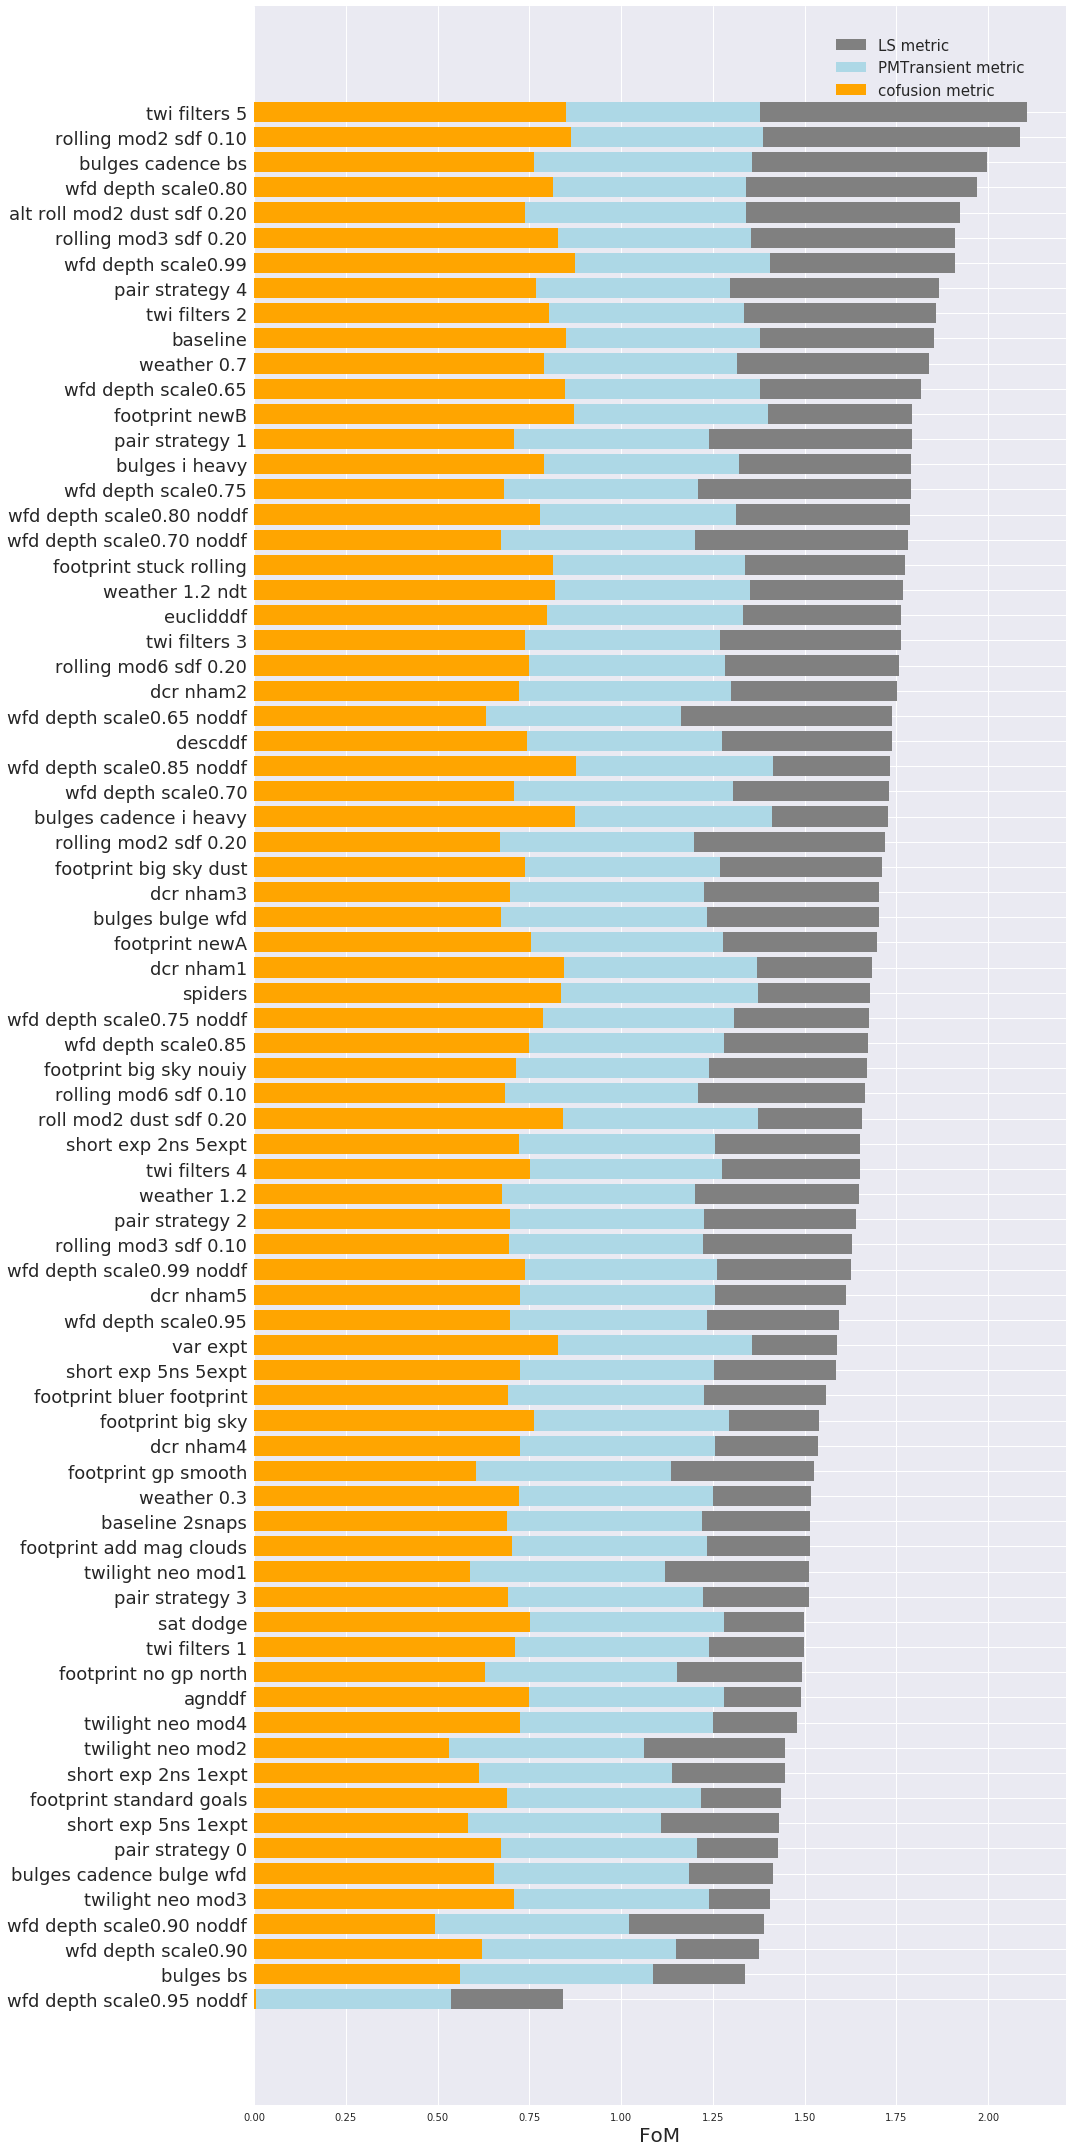

In [165]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20)
fig, ax = plt.subplots(figsize=(15,30))
y_pos = np.arange(len(name_tick))
ax.barh(y_pos,FomLS[idx]+FomC[idx]+FomPMT[idx], align='center',color='grey',label='LS metric')
ax.barh(y_pos,FomPMT[idx]+FomC[idx], align='center',color='lightblue' ,label='PMTransient metric')
ax.barh(y_pos,FomC[idx], align='center', color= 'orange',label='cofusion metric')
ax.set_yticks(y_pos[idx])
ax.set_yticklabels(name_tick, size=18)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('FoM', size=20)
ax.legend(bbox_to_anchor=(0.7, 0.95),fontsize=15)
plt.tight_layout()
#plt.savefig('FOM_astrometry_2yrs_DD.png')

In [21]:
data, hist  ={},{}
for key in bundleDicts.keys():
    data[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0]
    hist[key]={}
    hist[key]['LS']=[]
    hist[key]['LS_out']=[]
    for i in range(len(data[key])):        
        if data[key][i]:
            for j in range(len(data[key][i]['LS']['LS_PM'])):
                hist[key]['LS'].append(data[key][i]['LS']['LS_PM'][j])
            for k in range(len(data[key][i]['LS']['LS_PMout'])):
                hist[key]['LS_out'].append(data[key][i]['LS']['LS_PMout'][k])
    hist[key]['LS']=np.hstack(np.array(hist[key]['LS']))
    hist[key]['LS_out']=np.hstack(np.array(hist[key]['LS_out']))

IndexError: invalid index to scalar variable.

In [27]:
import seaborn as sn

Text(0.5, 0.98, 'Baseline 2 yrs')

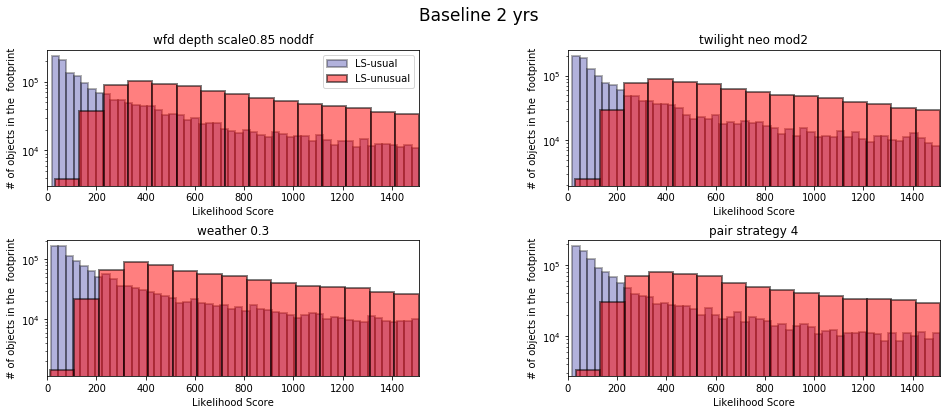

In [30]:
#fig = plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2, 2, figsize=(16,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, key in enumerate(dbRuns[0:4]):
    #value, bins = np.histogram(lam[key]['LS'], 50)
    #v_out, b_out = np.histogram(lam[key]['LS_out'],10)
    #ax = fig.add_subplot(2, 2, i+1)
    zeromaskLS =np.where(hist[key]['LS']!=0)
    plthist= pd.DataFrame(hist[key]['LS'][zeromaskLS])
    zeromask =np.where(hist[key]['LS_out']!=0)
    plthistout= pd.DataFrame(hist[key]['LS_out'][zeromask])
    sn.distplot(plthist, color="Darkblue", hist=True, kde=False,bins=50,hist_kws=dict(alpha=0.3,edgecolor="k", linewidth=2),ax=ax[i // 2][i % 2], label='LS-usual')
    sn.distplot(plthistout, color="red",  hist=True, kde=False,bins=15,hist_kws=dict(alpha=0.5,edgecolor="k", linewidth=2), ax=ax[i // 2][i % 2], label='LS-unusual')
    #ax.hist(lam[key]['LS'],10,alpha=.3,histtype='step',lw=3, color='black', label='LS-usual')
    #ax.hist(lam[key]['LS_out'],10,histtype='step',lw=3, color='orange', label='LS-unusual')
    ax[i // 2][i % 2].set_xlim([0,1510])
    ax[i // 2][i % 2].set_yscale('log')
    ax[i // 2][i % 2].set_xlabel('Likelihood Score')
    ax[i // 2][i % 2].set_ylabel('# of objects in the  footprint')
    ax[i // 2][i % 2].set_title('{}'.format(name_tick[i]))
    if i ==0:
        ax[i // 2][i % 2].legend()
plt.suptitle('Baseline 2 yrs', size=17)

### utils

In [42]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df

def get_pixId(df, nside=16):
    '''get pixId for each field'''
    pixId = RADec2pix(nside, ra=df['fieldRA'].values, dec=df['fieldDec'].values)
    df['pixId'] = pixId
    return df

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def radec2xyz(ra, dec):
    '''convert ra/dec to xyz'''
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    xyz = hp.ang2vec(theta, phi)
    
    return xyz

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

def gal2radec(gl, gb):
    '''convert gl/gb to ra/dec'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(l=gl, b=gb, frame="galactic",
                unit=(u.degree, u.degree))
    ra = c.icrs.ra.degree
    dec = c.icrs.dec.degree
    return ra, dec


# plot function
# plot skymap

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

def plot_filter_Nv(df, coord='C', figsize= (12, 6), colorbar=True, vmax=None, **kwargs):
    """plot number of visits in 6 filters"""
    
    fig, axs = plt.subplots(2, 3, figsize=figsize,
                            subplot_kw={'projection': 'mollweide'}); 
    axs = axs.ravel()
    FILTERS = ['u', 'g', 'r', 'i', 'z', 'y']
    for i, f in enumerate(FILTERS):
        
        df_f = df[ df['filter']==f ]
        if coord=='G':
            x = df_f['fieldGl'].values
            y = df_f['fieldGb'].values       
        else:
            x = df_f['fieldRA'].values
            y = df_f['fieldDec'].values
        c = df_f['Nv'].values
        if len(c)!=0:
            plot_mwd(axs[i], x, y, c, title=f, colorbar=colorbar, vmax=vmax, **kwargs)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].set_title(f)


In [ ]:
### utils

#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df

def get_pixId(df, nside=16):
    '''get pixId for each field'''
    pixId = RADec2pix(nside, ra=df['fieldRA'].values, dec=df['fieldDec'].values)
    df['pixId'] = pixId
    return df

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def radec2xyz(ra, dec):
    '''convert ra/dec to xyz'''
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    xyz = hp.ang2vec(theta, phi)
    
    return xyz

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

def gal2radec(gl, gb):
    '''convert gl/gb to ra/dec'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(l=gl, b=gb, frame="galactic",
                unit=(u.degree, u.degree))
    ra = c.icrs.ra.degree
    dec = c.icrs.dec.degree
    return ra, dec


# plot function
# plot skymap

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

def plot_filter_Nv(df, coord='C', figsize= (12, 6), colorbar=True, vmax=None, **kwargs):
    """plot number of visits in 6 filters"""
    
    fig, axs = plt.subplots(2, 3, figsize=figsize,
                            subplot_kw={'projection': 'mollweide'}); 
    axs = axs.ravel()
    FILTERS = ['u', 'g', 'r', 'i', 'z', 'y']
    for i, f in enumerate(FILTERS):
        
        df_f = df[ df['filter']==f ]
        if coord=='G':
            x = df_f['fieldGl'].values
            y = df_f['fieldGb'].values       
        else:
            x = df_f['fieldRA'].values
            y = df_f['fieldDec'].values
        c = df_f['Nv'].values
        if len(c)!=0:
            plot_mwd(axs[i], x, y, c, title=f, colorbar=colorbar, vmax=vmax, **kwargs)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].set_title(f)
